#Notebook báo cáo giữa kỳ
#Họ và tên: Nguyễn Huy Hoàng
#Lớp: 23DPM
#MSSV: 81012302865

## **I. Các thư viện cần thiết và thông tin cơ bản**


In [348]:
# Cài đặt thư viện cơ bản
!pip install numpy pandas matplotlib seaborn scikit-learn scipy wfdb tensorflow
!pip install diffusers accelerate

In [349]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import wfdb
import h5py
from scipy.signal import find_peaks
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0
NumPy version: 2.0.2
CUDA available: True
CUDA version: 12.4
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [350]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [351]:
def check_gpu_status():
    """Kiểm tra và hiển thị thông tin về GPU đang sử dụng"""
    if torch.cuda.is_available():
        print(f"GPU đang sử dụng: {torch.cuda.get_device_name(0)}")
        print(f"Bộ nhớ GPU được cấp phát: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"Bộ nhớ GPU dành riêng: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
    else:
        print("Không có GPU khả dụng. Sử dụng CPU.")

def set_seed(seed=42):
    """Đặt giá trị seed cho tính tái lập"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    tf.random.set_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Đã thiết lập seed = {seed}")

# Thiết lập để tái lập kết quả
set_seed()
check_gpu_status()

Đã thiết lập seed = 42
GPU đang sử dụng: Tesla T4
Bộ nhớ GPU được cấp phát: 314.03 MB
Bộ nhớ GPU dành riêng: 2384.00 MB


## **II. Tiền xử lý dữ liệu**

In [352]:
# Đường dẫn đến thư mục chứa dữ liệu BIDMC trên Google Drive
bidmc_data_path = '/content/drive/MyDrive/Big Data/bidmc/bidmc-ppg-and-respiration-dataset-1.0.0'

In [353]:
def list_bidmc_files(bidmc_data_path):
    """Liệt kê các file trong thư mục BIDMC."""
    print("Danh sách file trong thư mục BIDMC:")
    files = os.listdir(bidmc_data_path)
    print(files)
    return files # Thêm return để có thể sử dụng danh sách files sau này
# Lấy danh sách files
bidmc_files = list_bidmc_files(bidmc_data_path)

Danh sách file trong thư mục BIDMC:
['bidmc52.breath', 'bidmc09.breath', 'bidmc34n.hea', 'bidmc14.breath', 'bidmc36n.dat', 'bidmc20.dat', 'bidmc29.hea', 'bidmc32n.dat', 'bidmc12.breath', 'bidmc22n.hea', 'bidmc01.hea', 'bidmc10n.dat', 'bidmc52.dat', 'bidmc45.breath', 'bidmc29.breath', 'bidmc53.dat', 'bidmc49.dat', 'bidmc49.breath', 'bidmc51n.hea', 'bidmc20n.hea', 'bidmc19.breath', 'bidmc43.dat', 'bidmc36.dat', 'bidmc22.breath', 'bidmc11.breath', 'bidmc07.hea', 'bidmc30.dat', 'bidmc32.breath', 'bidmc01.dat', 'bidmc30n.hea', 'bidmc51n.dat', 'bidmc49.hea', 'bidmc24n.hea', 'bidmc10.dat', 'DBS', 'bidmc52n.hea', 'bidmc42.breath', 'bidmc41n.dat', 'bidmc45.hea', 'bidmc38n.hea', 'bidmc31n.dat', 'bidmc48.hea', 'bidmc05.hea', 'bidmc34.hea', 'bidmc14n.hea', 'bidmc27.dat', 'bidmc47.dat', 'bidmc38.hea', 'bidmc53n.dat', 'bidmc07n.hea', 'bidmc27n.dat', 'bidmc33.breath', 'bidmc38.breath', 'bidmc31.hea', 'bidmc02.dat', 'bidmc43.breath', 'bidmc37n.dat', 'bidmc04n.dat', 'bidmc05.breath', 'bidmc33n.dat', 'b

In [354]:
# Xác định các loại file có trong bộ dữ liệu BIDMC
def analyze_bidmc_file_types(files):
    """Phân tích và hiển thị các loại file có trong bộ dữ liệu BIDMC."""
    file_extensions = set([file.split('.')[-1] for file in files if '.' in file]) # lấy đuôi file
    print("Các loại file trong bộ dữ liệu BIDMC:")
    for ext in file_extensions:
        print(f"- .{ext}")
# Phân tích các loại file
analyze_bidmc_file_types(bidmc_files)

Các loại file trong bộ dữ liệu BIDMC:
- .breath
- .hea
- .mat
- .dat
- .txt


In [355]:
def load_data(file_path):
    """
    Đọc dữ liệu từ file .dat và .hea sử dụng thư viện wfdb.
    """
    try:
        record = wfdb.rdrecord(file_path)
        signals = record.p_signal
        sample_frequency = record.fs
        signal_names = record.sig_name
        units = record.units
        return signals, sample_frequency, signal_names, units
    except Exception as e:
        print(f"Lỗi đọc file: {e}")
        return None

In [356]:
def check_sample_frequency(sample_frequency, expected_frequency=125):
    """
    Kiểm tra xem tần số lấy mẫu có đúng với giá trị mong đợi hay không.
    """
    if sample_frequency == expected_frequency:
        return True
    else:
        return False

In [357]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """Áp dụng bộ lọc thông thấp Butterworth."""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y


def filter_signal(signal, cutoff, fs, order=5):
    """
    Áp dụng bộ lọc thông thấp Butterworth cho tín hiệu.
    """
    return butter_lowpass_filter(signal, cutoff, fs, order)

In [358]:
def detect_peaks(signal, threshold=0.5):
    """
    Tìm các đỉnh trong tín hiệu.
    """
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i-1] and signal[i] > signal[i+1] and signal[i] > threshold:
            peaks.append(i)
    return np.array(peaks)

Thông tin file mẫu: /content/drive/MyDrive/Big Data/bidmc/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc29
- Tần số lấy mẫu: 125 Hz
- Số kênh: 6
- Kênh: ['RESP,', 'PLETH,', 'CVP,', 'II,', 'V,', 'AVR,']
- Đơn vị:['pm', 'NU', 'mmHg', 'mV', 'mV', 'mV']


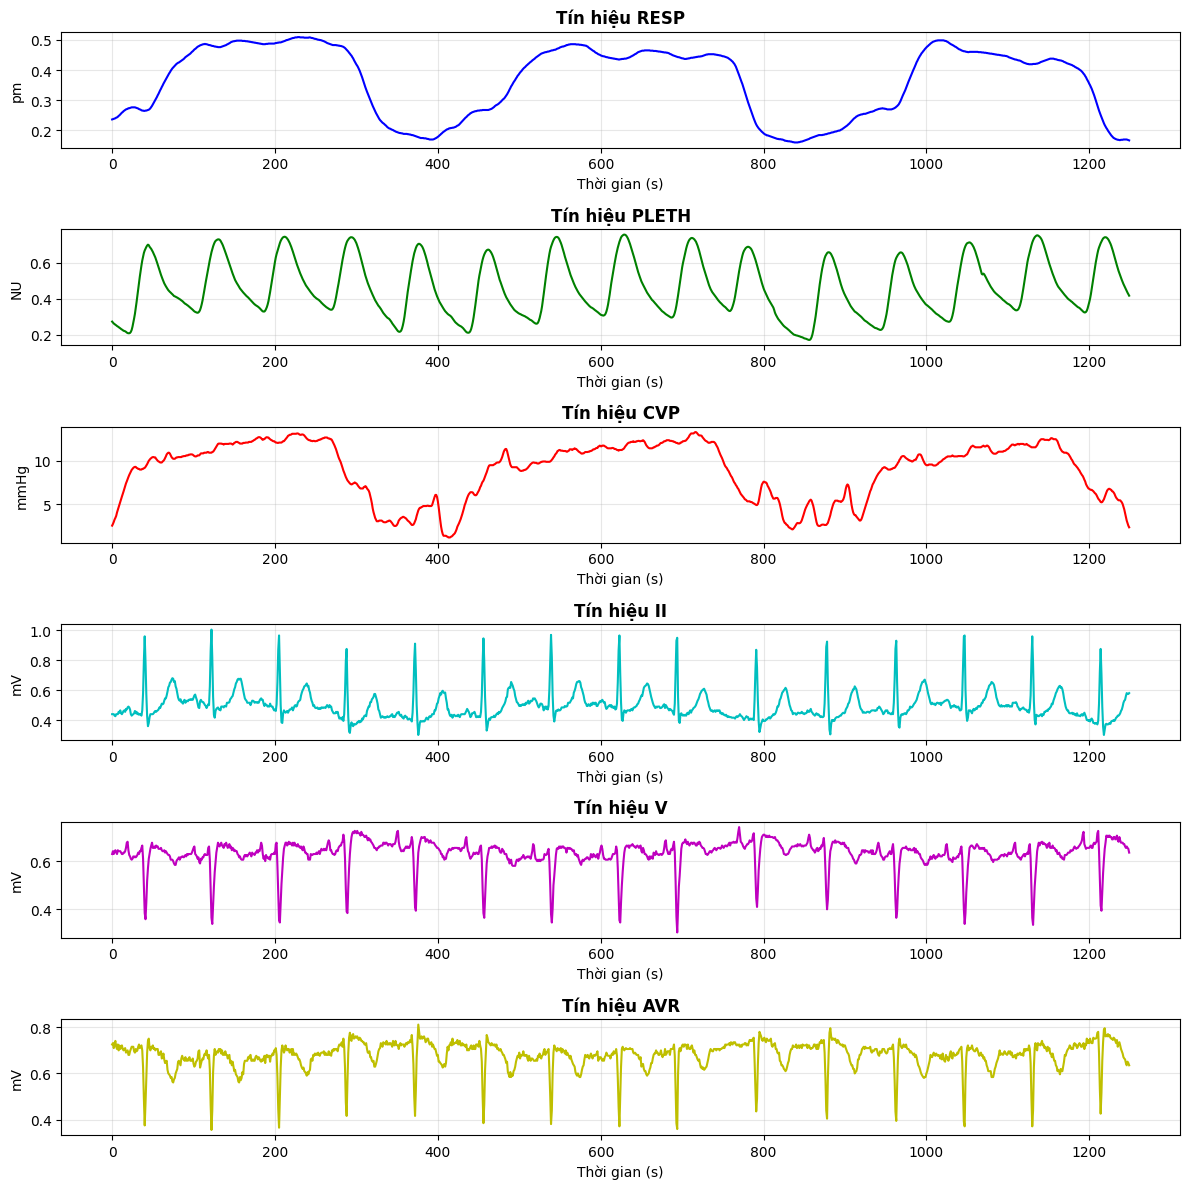

In [359]:
def explore_bidmc_dataset(bidmc_data_path):
    """Khám phá bộ dữ liệu BIDMC và vẽ đồ thị cho tất cả các kênh."""
    if not os.path.exists(bidmc_data_path):
        print("Thư mục dữ liệu không tồn tại!")
        return None

    # Tìm file .hea
    files = os.listdir(bidmc_data_path)
    hea_files = [file for file in files if file.endswith('.hea')]

    if not hea_files:
        print("Không tìm thấy file .hea nào!")
        return None

    for file in hea_files:
        sample_file = os.path.join(bidmc_data_path, os.path.splitext(file)[0])

        # Sử dụng hàm load_data
        data = load_data(sample_file)
        if data is None:
            continue  # Chuyển sang file tiếp theo nếu load lỗi

        signals, sample_frequency, signal_names, units = data

        # Kiểm tra tần số lấy mẫu
        if not check_sample_frequency(sample_frequency):
            continue  # Chuyển sang file tiếp theo nếu tần số không đúng

        print(f"Thông tin file mẫu: {sample_file}")
        print(f"- Tần số lấy mẫu: {sample_frequency} Hz")
        print(f"- Số kênh: {len(signal_names)}")
        print(f"- Kênh: {signal_names}")
        print(f"- Đơn vị:{units}")

        num_channels = len(signal_names)
        colors = ['b', 'g', 'r', 'c', 'm', 'y']

        plt.figure(figsize=(12, 2 * num_channels))

        seconds_to_show = 10
        samples_to_show = int(seconds_to_show * sample_frequency)

        for i in range(num_channels):
            plt.subplot(num_channels, 1, i + 1)
            plt.plot(signals[:samples_to_show, i], color=colors[i % len(colors)], linewidth=1.5)
            plt.title(f"Tín hiệu {signal_names[i].replace(',', '').strip().upper()}", fontsize=12, fontweight='bold')
            plt.ylabel(units[i])
            plt.grid(alpha=0.3)
            plt.xlabel("Thời gian (s)")

        plt.tight_layout()
        plt.show()
        return  # Kết thúc hàm sau khi xử lý thành công

    print("Không tìm thấy file nào có fs = 125Hz!")
    return None
explore_bidmc_dataset(bidmc_data_path)

Lọc tín hiệu cho mẫu dữ liệu /content/drive/MyDrive/Big Data/bidmc/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc29



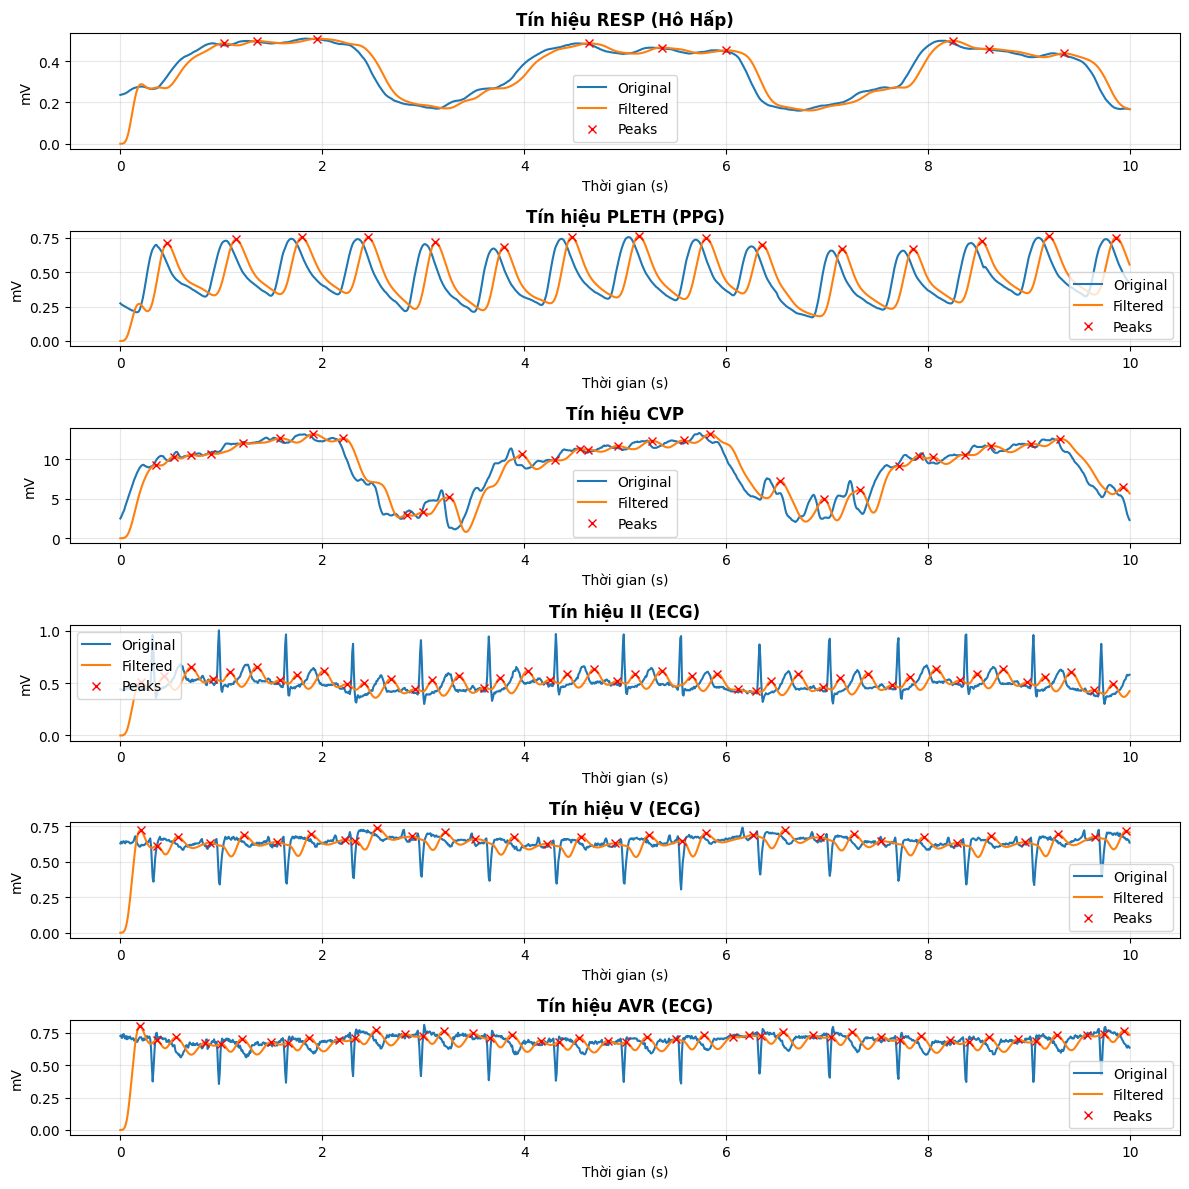

In [360]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np

def filter_bidmc_dataset(example_path):
    """Lọc tín hiệu, tìm đỉnh và vẽ đồ thị."""
    # Sử dụng hàm load_data
    data = load_data(example_path)
    if data is None:
        return None  # Kết thúc hàm nếu load lỗi

    signals, sample_frequency, signal_names, units = data

    # Kiểm tra tần số lấy mẫu
    if not check_sample_frequency(sample_frequency):
        return None  # Kết thúc hàm nếu tần số không đúng

    print(f"Lọc tín hiệu cho mẫu dữ liệu {example_path}\n")
    fs = sample_frequency
    num_channels = len(signal_names)
    units = ["mV"] * num_channels

    plt.figure(figsize=(12, 2 * num_channels))

    seconds_to_show = 10
    samples_to_show = int(seconds_to_show * fs)
    time = np.arange(0, seconds_to_show, 1/fs)  # Tạo trục thời gian

    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        signal = signals[:samples_to_show, i]

        # Lọc tín hiệu
        filtered_signal = filter_signal(signal, cutoff=5, fs=fs)

        # Tìm đỉnh
        peaks = detect_peaks(filtered_signal, threshold=0.4)
        peak_values = filtered_signal[peaks]

        # Vẽ đồ thị
        plt.plot(time, signal, linewidth=1.5, label='Original')
        plt.plot(time, filtered_signal, linewidth=1.5, label='Filtered')
        plt.plot(time[peaks], peak_values, 'rx', label='Peaks')

        channel_name = signal_names[i].replace(',', '').strip().upper()
        vietnamese_names = {
            "RESP": "RESP (Hô Hấp)",
            "PLETH": "PLETH (PPG)",
            "CVP": "CVP",
            "II": "II (ECG)",
            "V": "V (ECG)",
            "AVR": "AVR (ECG)"
        }
        title = f"Tín hiệu {vietnamese_names.get(channel_name, channel_name)}"
        plt.title(title, fontsize=12, fontweight='bold')
        plt.ylabel(units[i])
        plt.xlabel("Thời gian (s)")
        plt.grid(alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()
    return None

# Đường dẫn đến mẫu dữ liệu
example_path = '/content/drive/MyDrive/Big Data/bidmc/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc29'
filter_bidmc_dataset(example_path)

In [361]:
import os

def get_record_ids(data_dir):
    """
    Lấy danh sách các record ID từ thư mục dữ liệu BIDMC.
    """
    record_ids = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".hea"):
            record_id = filename[:-4]  # Bỏ phần ".hea"
            record_ids.append(record_id)
    return record_ids

In [362]:
import wfdb
import numpy as np

def load_record(data_dir, record_id):
    """
    Load một record cụ thể từ thư mục dữ liệu BIDMC.
    """
    try:
        record = wfdb.rdrecord(os.path.join(data_dir, record_id))
        signals = record.p_signal
        fields = record.__dict__  # Lấy tất cả thông tin record vào một dictionary
        return signals, fields
    except Exception as e:
        print(f"Lỗi load record {record_id}: {e}")
        return None

In [363]:
def select_channels(signals, fields, channel_names):
    """
    Chọn các kênh cụ thể từ dữ liệu tín hiệu (tìm kiếm linh hoạt).
    """
    try:
        indices = []
        for keyword in channel_names:
            found_indices = [i for i, name in enumerate(fields['sig_name']) if keyword.lower() in name.lower()]
            if found_indices:
                indices.append(found_indices[0])  # Chỉ lấy kênh đầu tiên tìm thấy
            else:
                return None  # Trả về None nếu không tìm thấy bất kỳ kênh nào

        selected_signals = signals[:, indices]
        return selected_signals
    except ValueError as e:
        print(f"Lỗi chọn kênh: {e}")
        return None

In [364]:
from torch.utils.data import DataLoader

def create_data_loader(dataset, batch_size=32, shuffle=True):
    """
    Tạo DataLoader từ Dataset.
    """
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

In [365]:
import numpy as np

def normalize_min_max(signal):
    """
    Chuẩn hóa tín hiệu về khoảng [0, 1] bằng Min-Max Scaling.
    """
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val + 1e-8)  # Thêm 1e-8 để tránh chia cho 0

In [366]:
class RecordInfo:
    """
    Lưu trữ thông tin về một record BIDMC.
    """
    def __init__(self, record_id, signals, hr, br):
        self.record_id = record_id
        self.signals = signals
        self.hr = hr
        self.br = br

In [367]:
def estimate_hr_from_ppg(ppg_signal, fs=125):
    if np.std(ppg_signal) < 1e-3:  # Biến thiên quá nhỏ → noise
        return None, None

    try:
        ppg_signal = (ppg_signal - np.mean(ppg_signal)) / np.std(ppg_signal)

        # Tăng độ chính xác peak detection
        peaks, _ = find_peaks(ppg_signal, distance=fs*0.4, prominence=0.2, width=3)

        if len(peaks) < 2:
            return None, peaks

        rr_intervals = np.diff(peaks) / fs
        hr = 60 / np.mean(rr_intervals)

        # Giới hạn HR thực tế
        if hr < 40 or hr > 180:
            return None, peaks

        return hr, peaks
    except:
        return None, None

In [368]:
def estimate_br_from_ppg(ppg_signal, fs=125):
    if np.std(ppg_signal) < 1e-3:
        return None

    try:
        # Bộ lọc mạnh hơn (cắt ở 0.4Hz ~ 24 bpm)
        def butter_lowpass_filter(data, cutoff=0.4, fs=fs, order=5):
            nyq = 0.5 * fs
            normal_cutoff = cutoff / nyq
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            y = filtfilt(b, a, data)
            return y

        filtered = butter_lowpass_filter(ppg_signal)
        envelope = np.abs(hilbert(filtered))
        envelope = (envelope - np.mean(envelope)) / np.std(envelope)

        peaks, _ = find_peaks(envelope, distance=fs*1.5, prominence=0.2)

        if len(peaks) < 2:
            return None

        rr_intervals = np.diff(peaks) / fs
        br = 60 / np.mean(rr_intervals)

        # Giới hạn hợp lý
        if br < 6 or br > 40:
            return None

        return br
    except:
        return None

In [369]:
import tensorflow as tf

def compute_total_loss(ppg_true, ppg_pred, mu, log_var, fs=125,
                       alpha_hr=1.0, alpha_br=1.0, beta_kl=0.001):
    # Reconstruction loss
    recon_loss = tf.reduce_mean(tf.square(ppg_true - ppg_pred))

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))

    # Chuyển về numpy để trích HR/BR
    ppg_true_np = ppg_true.numpy().flatten()
    ppg_pred_np = ppg_pred.numpy().flatten()

    hr_true = estimate_hr_from_ppg(ppg_true_np, fs)
    hr_pred = estimate_hr_from_ppg(ppg_pred_np, fs)

    br_true = estimate_br_from_ppg(ppg_true_np, fs)
    br_pred = estimate_br_from_ppg(ppg_pred_np, fs)

    # Nếu không thể tính HR/BR → không tính loss phụ
    loss_hr = tf.constant(0.0)
    loss_br = tf.constant(0.0)

    if hr_true is not None and hr_pred is not None:
        loss_hr = tf.square(hr_pred - hr_true)

    if br_true is not None and br_pred is not None:
        loss_br = tf.square(br_pred - br_true)

    # Tổng hợp loss
    total_loss = recon_loss + beta_kl * kl_loss + alpha_hr * loss_hr + alpha_br * loss_br
    return total_loss

In [370]:
from scipy.signal import find_peaks

def estimate_br_from_resp_peaks(resp_signal, fs):
    """
    Ước tính nhịp thở (BR) từ tín hiệu RESP bằng peak detection.
    """
    try:
        resp_signal = butter_lowpass_filter(resp_signal, cutoff=0.5, fs=fs, order=3)
        peaks, _ = find_peaks(resp_signal, distance=fs * 1.5)

        if len(peaks) > 1:
            peak_intervals = np.diff(peaks) / fs
            mean_interval = np.mean(peak_intervals)
            br = 60 / mean_interval

            # Giới hạn giá trị BR
            br = np.clip(br, 6, 40)

            return br
        else:
            return None
    except Exception as e:
        print(f"Lỗi ước tính BR từ RESP: {e}")
        return None

In [371]:
import torch
from torch.utils.data import Dataset
import numpy as np
from scipy.stats import zscore
from scipy.signal import find_peaks

class BIDMC_Dataset(Dataset):
    """
    PyTorch Dataset cho dữ liệu BIDMC.
    """
    def __init__(self, data_dir, record_ids, channel_names=['PLETH', 'RESP'], segment_length=1250, transform=None):
        """
        Khởi tạo Dataset.
        """
        self.data_dir = data_dir
        self.record_ids = record_ids
        self.channel_names = channel_names
        self.segment_length = segment_length
        self.transform = transform
        self.data = []  # Danh sách để lưu trữ dữ liệu đã load
        self.hr_values = []  # Danh sách để lưu trữ giá trị HR
        self.br_values = []  # Danh sách để lưu trữ giá trị BR

        # Load dữ liệu
        for record_id in self.record_ids:
            record = load_record(self.data_dir, record_id)

            if record is not None:
                signals, fields = record
                fs = fields['fs']

                selected_signals = select_channels(signals, fields, self.channel_names)

                if selected_signals is not None:
                    pleth_signal = selected_signals[:, 0]  # Lấy kênh PLETH
                    if selected_signals.shape[1] > 1:
                        resp_signal = selected_signals[:, 1]  # Lấy kênh RESP
                    else:
                        resp_signal = None

                    for i in range(0, len(pleth_signal) - self.segment_length + 1, self.segment_length):
                        segment = pleth_signal[i:i + self.segment_length]
                        self.data.append(segment)

                        hr, _ = estimate_hr_from_ppg(segment, fs)  # Ước tính HR  # Ước tính HR

                        if hr is not None:
                            self.hr_values.append(hr)
                        else:
                            self.hr_values.append(np.nan)  # Gán NaN nếu không ước tính được HR

                        if resp_signal is not None:
                            br = estimate_br_from_resp_peaks(resp_signal[i:i + self.segment_length], fs)
                            if br is not None:
                                self.br_values.append(br)
                            else:
                                self.br_values.append(np.nan)  # Gán NaN nếu không ước tính được BR
                        else:
                            self.br_values.append(np.nan)

        # Loại bỏ các giá trị NaN
        valid_indices = [i for i, (hr, br) in enumerate(zip(self.hr_values, self.br_values)) if not np.isnan(hr) and not np.isnan(br)]
        self.data = [self.data[i] for i in valid_indices]
        self.hr_values = [self.hr_values[i] for i in valid_indices]
        self.br_values = [self.br_values[i] for i in valid_indices]


        self.hr_values_normalized = zscore(self.hr_values)
        self.br_values_normalized = zscore(self.br_values)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        hr = self.hr_values_normalized[idx] # Chuẩn hoá hr, br
        br = self.br_values_normalized[idx]

        signal = normalize_min_max(signal)

        signal = torch.tensor(signal, dtype=torch.float32)
        hr = torch.tensor(hr, dtype=torch.float32).unsqueeze(0)
        br = torch.tensor(br, dtype=torch.float32).unsqueeze(0)

        return signal, hr, br # Trả về cả 3 giá trị

Số lượng record sử dụng được: 2539
Batch 0:
- Shape của batch signals: torch.Size([32, 1250])
- Shape của batch hr: torch.Size([32, 1])
- Shape của batch br: torch.Size([32, 1])
Một vài giá trị HR: [np.float64(89.36170212765958), np.float64(90.43927648578811), np.float64(91.30434782608695), np.float64(90.75194468452897), np.float64(90.90909090909092), np.float64(89.43781942078365), np.float64(87.93969849246231), np.float64(90.28374892519348), np.float64(90.05145797598628), np.float64(89.36170212765957)]
Một vài giá trị BR: [np.float64(17.045454545454547), np.float64(18.58736059479554), np.float64(20.435967302452315), np.float64(21.408182683158895), np.float64(19.815059445178335), np.float64(20.435967302452315), np.float64(20.27027027027027), np.float64(22.123893805309738), np.float64(19.132653061224488), np.float64(22.55639097744361)]


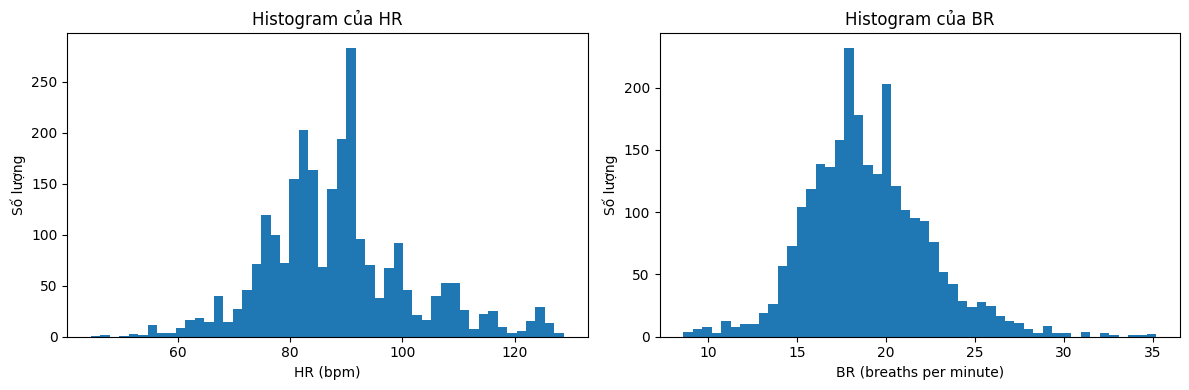

In [372]:
import torch
from torch.utils.data import DataLoader

# Chuẩn bị dữ liệu
data_dir = '/content/drive/MyDrive/Big Data/bidmc/bidmc-ppg-and-respiration-dataset-1.0.0'
record_ids = get_record_ids(data_dir)  # Lấy tất cả record IDs
channel_names = ['PLETH', 'RESP', 'II']

# Tạo Dataset
dataset = BIDMC_Dataset(data_dir=data_dir, record_ids=record_ids, channel_names=channel_names)

# Kiểm tra kích thước dataset
print(f"Số lượng record sử dụng được: {len(dataset)}")

# Tạo DataLoader (chỉ tạo nếu có dữ liệu)
if len(dataset) > 0:
    data_loader = create_data_loader(dataset, batch_size=32, shuffle=True)

    # Duyệt qua DataLoader (chỉ duyệt nếu có dữ liệu)
    for batch_idx, batch_data in enumerate(data_loader):
        signals, hr, br = batch_data  # Giải nén tuple
        print(f"Batch {batch_idx}:")
        print(f"- Shape của batch signals: {signals.shape}")
        print(f"- Shape của batch hr: {hr.shape}")
        print(f"- Shape của batch br: {br.shape}")
        break  # Chỉ in thông tin của batch đầu tiên
else:
    print("Không có dữ liệu để tạo DataLoader.")

# Lấy danh sách giá trị HR và BR
hr_values = dataset.hr_values
br_values = dataset.br_values

# In một vài giá trị HR và BR
print("Một vài giá trị HR:", hr_values[:10])
print("Một vài giá trị BR:", br_values[:10])

# Tạo subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột

# Vẽ histogram của HR
axes[0].hist(hr_values, bins=50)
axes[0].set_title("Histogram của HR")
axes[0].set_xlabel("HR (bpm)")
axes[0].set_ylabel("Số lượng")

# Vẽ histogram của BR
axes[1].hist(br_values, bins=50)
axes[1].set_title("Histogram của BR")
axes[1].set_xlabel("BR (breaths per minute)")
axes[1].set_ylabel("Số lượng")

plt.tight_layout()  # Điều chỉnh khoảng cách giữa các subplot
plt.show()

In [373]:
from sklearn.model_selection import train_test_split

def create_train_test_datasets(data_dir, record_ids, channel_names=['PLETH'], segment_length=1250, test_size=0.2):
    """
    Chia dữ liệu thành tập train và tập test.
    """
    # Chia danh sách record IDs thành tập train và tập test
    train_ids, test_ids = train_test_split(record_ids, test_size=test_size, random_state=42)  # Đặt random_state để đảm bảo tính tái lập

    # Tạo Dataset cho tập train và tập test
    train_dataset = BIDMC_Dataset(data_dir=data_dir, record_ids=train_ids, channel_names=channel_names, segment_length=segment_length)
    test_dataset = BIDMC_Dataset(data_dir=data_dir, record_ids=test_ids, channel_names=channel_names, segment_length=segment_length)

    return train_dataset, test_dataset

## **III. Mô hình DenseCVAE**

In [374]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseCVAE(nn.Module):
    def __init__(self, seq_len=1250, cond_dim=2, latent_dim=20, hidden_dim1=512, hidden_dim2=256, hidden_dim3=128):
        super(DenseCVAE, self).__init__()

        self.seq_len = seq_len
        self.cond_dim = cond_dim
        self.latent_dim = latent_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3

        # Encoder
        self.encoder_fc1 = nn.Linear(seq_len + cond_dim, hidden_dim1)
        self.encoder_bn1 = nn.BatchNorm1d(hidden_dim1)  # Batch Normalization
        self.encoder_fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.encoder_bn2 = nn.BatchNorm1d(hidden_dim2)  # Batch Normalization
        self.encoder_fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.encoder_bn3 = nn.BatchNorm1d(hidden_dim3)  # Batch Normalization
        self.encoder_mu = nn.Linear(hidden_dim3, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim3, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim + cond_dim, hidden_dim3)
        self.decoder_bn1 = nn.BatchNorm1d(hidden_dim3)  # Batch Normalization
        self.decoder_fc2 = nn.Linear(hidden_dim3, hidden_dim2)
        self.decoder_bn2 = nn.BatchNorm1d(hidden_dim2)  # Batch Normalization
        self.decoder_fc3 = nn.Linear(hidden_dim2, hidden_dim1)
        self.decoder_bn3 = nn.BatchNorm1d(hidden_dim1)  # Batch Normalization
        self.decoder_fc4 = nn.Linear(hidden_dim1, seq_len)

        # Nhánh dự đoán HR và BR
        self.hr_output = nn.Linear(hidden_dim1, 1)
        self.br_output = nn.Linear(hidden_dim1, 1)

    def encode(self, x, cond):
        x = torch.cat([x, cond.squeeze(1)], dim=1)
        h = F.relu(self.encoder_bn1(self.encoder_fc1(x))) # Batch Normalization
        h = F.relu(self.encoder_bn2(self.encoder_fc2(h))) # Batch Normalization
        h = F.relu(self.encoder_bn3(self.encoder_fc3(h))) # Batch Normalization
        mu = self.encoder_mu(h)
        logvar = self.encoder_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        z = torch.cat([z, cond.squeeze(1)], dim=1)
        h = F.relu(self.decoder_bn1(self.decoder_fc1(z)))
        h = F.relu(self.decoder_bn2(self.decoder_fc2(h)))
        h = F.relu(self.decoder_bn3(self.decoder_fc3(h)))

        x_recon = torch.sigmoid(self.decoder_fc4(h))
        hr_pred = self.hr_output(h)
        br_pred = self.br_output(h)

        return x_recon, hr_pred, br_pred


    def forward(self, x, cond):
        mu, logvar = self.encode(x, cond)
        z = self.reparameterize(mu, logvar)
        x_recon, hr_pred, br_pred = self.decode(z, cond)
        return x_recon, mu, logvar, hr_pred, br_pred

In [375]:
def multitask_cvae_loss(recon_x, x, mu, logvar, hr_pred, br_pred, hr_true, br_true,
                        alpha_hr=1.0, alpha_br=1.0, beta_kl=0.001):
    recon_loss = F.mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    hr_loss = F.mse_loss(hr_pred.squeeze(), hr_true.squeeze())
    br_loss = F.mse_loss(br_pred.squeeze(), br_true.squeeze())

    total_loss = recon_loss + beta_kl * kl_loss + alpha_hr * hr_loss + alpha_br * br_loss
    return total_loss

In [376]:
import tqdm

def train_dense_cvae(model, train_loader, optimizer, num_epochs, device):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        loop = tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        for batch_idx, (signals, hr, br) in loop:
            signals = signals.to(device)
            hr = hr.to(device)
            br = br.to(device)

            optimizer.zero_grad()

            recon_x, mu, logvar, hr_pred, br_pred = model(signals, torch.cat([hr, br], dim=1))
            loss = multitask_cvae_loss(recon_x, signals, mu, logvar, hr_pred, br_pred, hr, br)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # Cộng dồn loss
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        # In loss trung bình cuối epoch
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

In [377]:
import torch
import torch.nn.functional as F

def evaluate_reconstruction(recon_x, x, mu, logvar, br_gt, alpha=0.9, fs=125):
    """
    Đánh giá chất lượng tái tạo của một tín hiệu.
    """
    # Reconstruction loss + KL divergence
    recon_loss = F.mse_loss(recon_x, x, reduction='sum').item()
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).item()
    loss = alpha * recon_loss + (1 - alpha) * 0.01 * kl_loss

    # HR estimation
    hr_diff = 0
    hr_est, _ = estimate_hr_from_ppg(recon_x.cpu().numpy(), fs)
    if hr_est is not None:
        hr_diff = np.abs(hr_est - 75)  # Giả định HR trung bình là 75 BPM

    # BR estimation
    br_diff = 0
    br_est = estimate_br_from_ppg(recon_x.cpu().numpy(), fs)
    if br_est is not None:
        br_diff = np.abs(br_est - br_gt)  # So sánh với ground truth BR đầu vào

    # Tính tổng điểm đánh giá, penalize theo HR và BR
    score = -loss - 0.1 * hr_diff - 0.1 * br_diff

    return score

In [378]:
def visualize_reconstruction_dense_cvae(model, data_loader, device, fs, dataset, num_samples=5):

    model.eval()  # Chuyển mô hình sang chế độ đánh giá

    reconstructions = []  # Danh sách để lưu trữ các tín hiệu tái tạo và thông tin của chúng

    with torch.no_grad():  # Tắt tính toán gradient
        for i, (signals, hr, br) in enumerate(data_loader):
            # Chuyển dữ liệu lên thiết bị
            signals = signals.to(device)
            hr = hr.to(device)
            br = br.to(device)

            # Forward pass
            recon_x, mu, logvar, hr_pred, br_pred = model(signals, torch.cat([hr, br], dim=1))

            # Lặp qua các mẫu và tính điểm đánh giá
            for j in range(signals.size(0)):
                original_signal = signals[j].cpu().numpy()
                reconstructed_signal = recon_x[j].cpu().numpy()

                # Calculate score
                _, _, _, hr_pred, br_pred = model(signals[j].unsqueeze(0), torch.cat([hr[j].unsqueeze(0), br[j].unsqueeze(0)], dim=1))
                score = evaluate_reconstruction(recon_x[j], signals[j], mu[j], logvar[j], br[j].item(), fs)

                # Lưu trữ tín hiệu và thông tin
                reconstructions.append({
                    "original": original_signal,
                    "reconstructed": reconstructed_signal,
                    "hr": hr[j].item(),
                    "br": br[j].item(),
                    "score": score
                })

    # Sắp xếp các tín hiệu theo điểm đánh giá (từ cao đến thấp)
    reconstructions = sorted(reconstructions, key=lambda x: x["score"], reverse=True)

    # Lặp qua các mẫu và vẽ biểu đồ
    for j in range(min(num_samples, len(reconstructions))):
        # Lấy tín hiệu gốc và tín hiệu tái tạo
        original_signal = reconstructions[j]["original"]
        reconstructed_signal = reconstructions[j]["reconstructed"]
        hr = reconstructions[j]["hr"]
        br = reconstructions[j]["br"]

        # Tạo biểu đồ
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(original_signal)) / fs, original_signal, label='Original PPG', alpha=0.7)
        plt.plot(np.arange(len(reconstructed_signal)) / fs, reconstructed_signal, label='Reconstructed PPG', alpha=0.7, linestyle='--')

        hr_mean = np.mean(dataset.hr_values)
        hr_std = np.std(dataset.hr_values)
        br_mean = np.mean(dataset.br_values)
        br_std = np.std(dataset.br_values)

        hr_gt_real = hr * hr_std + hr_mean
        br_gt_real = br * br_std + br_mean

        hr_pred_real = hr_pred.item() * hr_std + hr_mean
        br_pred_real = br_pred.item() * br_std + br_mean

        plt.title(f"Original vs Reconstructed PPG (DenseCVAE)\n"
                  f"HR: GT={hr_gt_real:.1f} | Pred={hr_pred_real:.1f} BPM   "
                  f"BR: GT={br_gt_real:.1f} | Pred={br_pred_real:.1f} BPM")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [379]:
import torch.optim as optim
# Chọn thiết bị (GPU nếu có, CPU nếu không)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Khởi tạo mô hình DenseCVAE
seq_len = 1250  # Độ dài của tín hiệu PPG
latent_dim = 20  # Số chiều của vector latent
cond_dim = 2

dense_model = DenseCVAE(seq_len=seq_len, latent_dim=latent_dim, cond_dim = cond_dim)

# Tạo optimizer cho mô hình DenseCVAE
dense_optimizer = optim.Adam(dense_model.parameters(), lr=0.001)

# Tạo DataLoader cho tập train (sử dụng BIDMC_Dataset)
data_dir = '/content/drive/MyDrive/Big Data/bidmc/bidmc-ppg-and-respiration-dataset-1.0.0'
record_ids = get_record_ids(data_dir)
channel_names = ['PLETH','RESP'] #Thay đổi channel_names

train_dataset, test_dataset = create_train_test_datasets(data_dir=data_dir, record_ids=record_ids, channel_names=channel_names)
batch_size = 32
train_loader = create_data_loader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = create_data_loader(test_dataset, batch_size=batch_size, shuffle=False)


# Train mô hình DenseCVAE
num_epochs = 50 # Giảm số epoch để quá trình train nhanh hơn
train_dense_cvae(dense_model, train_loader, dense_optimizer, num_epochs, device)

print(f"\nHuấn luyện mô hình CVAE Dense thành công")

Epoch 1: Loss = 0.6122


Epoch 2: Loss = 0.3009


Epoch 3: Loss = 0.2403


Epoch 4: Loss = 0.2144


Epoch 5: Loss = 0.2051


Epoch 6: Loss = 0.1798


Epoch 7: Loss = 0.1957


Epoch 8: Loss = 0.2114


Epoch 9: Loss = 0.1998


Epoch 10: Loss = 0.1650


Epoch 11: Loss = 0.1970


Epoch 12: Loss = 0.1668


Epoch 13: Loss = 0.1636


Epoch 14: Loss = 0.1377


Epoch 15: Loss = 0.1355


Epoch 16: Loss = 0.1534


Epoch 17: Loss = 0.1542


Epoch 18: Loss = 0.1627


Epoch 19: Loss = 0.1283


Epoch 20: Loss = 0.1382


Epoch 21: Loss = 0.1548


Epoch 22: Loss = 0.1223


Epoch 23: Loss = 0.1290


Epoch 24: Loss = 0.1135


Epoch 25: Loss = 0.1322


Epoch 26: Loss = 0.1303


Epoch 27: Loss = 0.1204


Epoch 28: Loss = 0.1200


Epoch 29: Loss = 0.1323


Epoch 30: Loss = 0.1075


Epoch 31: Loss = 0.1054


Epoch 32: Loss = 0.1260


Epoch 33: Loss = 0.1006


Epoch 34: Loss = 0.1188


Epoch 35: Loss = 0.1146


Epoch 36: Loss = 0.0986


Epoch 37: Loss = 0.0950


Epoch 38: Loss = 0.1261


Epoch 39: Loss = 0.1152


Epoch 40: Loss = 0.1219


Epoch 41: Loss = 0.0904


Epoch 42: Loss = 0.0937


Epoch 43: Loss = 0.1124


Epoch 44: Loss = 0.0876


Epoch 45: Loss = 0.0886


Epoch 46: Loss = 0.0973


Epoch 47: Loss = 0.0988


Epoch 48: Loss = 0.0973


Epoch 49: Loss = 0.1126


Epoch 50: Loss = 0.0964

Huấn luyện mô hình CVAE Dense thành công


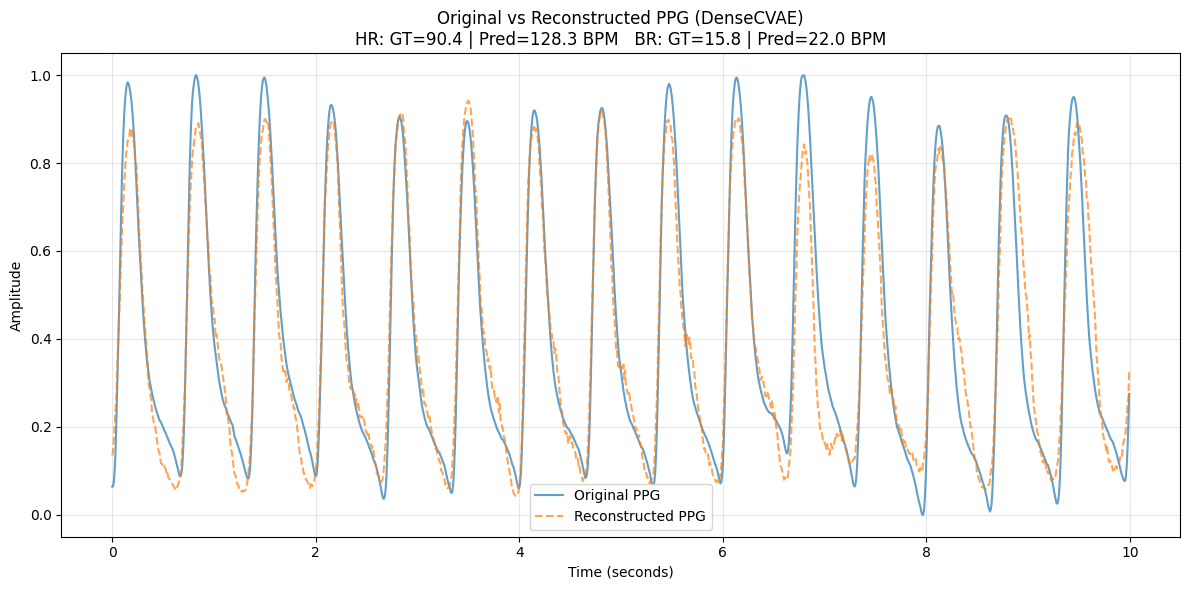

In [380]:
visualize_reconstruction_dense_cvae(
    model=dense_model,
    data_loader=test_loader,
    device=device,
    fs=125,
    dataset=test_dataset,
    num_samples=1
)

In [381]:
def evaluate_model_hr_br(model, data_loader, device, dataset):
    """
    Đánh giá sai số trung bình HR và BR theo đơn vị BPM thực tế.
    Yêu cầu truyền thêm 'dataset' để truy cập mean và std để unnormalize.
    """
    model.eval()
    hr_errors = []
    br_errors = []

    hr_array = np.array(dataset.hr_values)
    br_array = np.array(dataset.br_values)

    hr_mean = hr_array.mean()
    hr_std = hr_array.std()
    br_mean = br_array.mean()
    br_std = br_array.std()

    with torch.no_grad():
        for signals, hr_true_norm, br_true_norm in data_loader:
            signals = signals.to(device)
            hr_true_norm = hr_true_norm.to(device)
            br_true_norm = br_true_norm.to(device)

            # Forward
            _, _, _, hr_pred_norm, br_pred_norm = model(signals, torch.cat([hr_true_norm, br_true_norm], dim=1))

            # Chuẩn hóa ngược
            hr_true = hr_true_norm * hr_std + hr_mean
            hr_pred = hr_pred_norm * hr_std + hr_mean
            br_true = br_true_norm * br_std + br_mean
            br_pred = br_pred_norm * br_std + br_mean

            # Sai số tuyệt đối
            hr_error = torch.abs(hr_pred.squeeze() - hr_true.squeeze())
            br_error = torch.abs(br_pred.squeeze() - br_true.squeeze())

            hr_errors.extend(hr_error.cpu().numpy())
            br_errors.extend(br_error.cpu().numpy())

    # Trung bình
    avg_hr_error = np.mean(hr_errors)
    avg_br_error = np.mean(br_errors)

    print(f"Sai số trung bình toàn tập test dataset DenseCVAE:")
    print(f"- HR: {avg_hr_error:.2f} BPM")
    print(f"- BR: {avg_br_error:.2f} BPM")
evaluate_model_hr_br(dense_model, test_loader, device, dataset=test_dataset)

Sai số trung bình toàn tập test dataset DenseCVAE:
- HR: 1.52 BPM
- BR: 0.32 BPM


## **IV. Mô hình Conv1DCVAE**

In [382]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv1DCVAE(nn.Module):
    def __init__(self, seq_len=1250, latent_dim=32, cond_dim=2):
        super().__init__()
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.flatten_dim = self._get_flatten_dim()
        self.reshape_shape = self._get_reshape_shape()
        self.fc1 = nn.Linear(self.flatten_dim + cond_dim, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim + cond_dim, self.flatten_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=3, padding=1)
        )

        # HR/BR output heads
        self.hr_output = nn.Linear(256, 1)
        self.br_output = nn.Linear(256, 1)

    def _get_flatten_dim(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, self.seq_len)
            return self.encoder(dummy).view(1, -1).shape[1]

    def _get_reshape_shape(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, self.seq_len)
            return self.encoder(dummy).shape[1:]  # (C, L)

    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, c], dim=1)
        h = self.fc1(x)
        return self.fc_mu(h), self.fc_logvar(h), h

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        x = self.decoder_fc(z)
        x = x.view(x.size(0), *self.reshape_shape)
        x = self.decoder(x)
        return x[..., :self.seq_len]

    def forward(self, x, c):
        mu, logvar, h = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        hr_pred = self.hr_output(h)
        br_pred = self.br_output(h)
        return x_recon, mu, logvar, hr_pred, br_pred

In [383]:
def conv1d_cvae_loss_multitask(recon_x, x, mu, logvar, hr_pred, br_pred, hr_gt, br_gt,
                               alpha_recon=1.0, alpha_hr=0.1, alpha_br=0.1, kl_weight=0.001):
    recon_loss = F.smooth_l1_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    hr_loss = F.mse_loss(hr_pred, hr_gt, reduction='mean')
    br_loss = F.mse_loss(br_pred, br_gt, reduction='mean')

    return alpha_recon * recon_loss + kl_weight * kl_loss + alpha_hr * hr_loss + alpha_br * br_loss


In [384]:
from tqdm import tqdm

def train_conv1d_cvae(model, train_loader, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in loop:
            signals, hr, br = [item.to(device) for item in batch]

            cond = torch.cat([hr, br], dim=1)

            optimizer.zero_grad()
            # Ép tín hiệu về đúng shape (B, 1, L)
            if signals.ndim == 2:
                signals = signals.unsqueeze(1)  # (B, L) -> (B, 1, L)
            recon_x, mu, logvar, hr_pred, br_pred = model(signals, cond)

            loss = conv1d_cvae_loss_multitask(
                recon_x, signals, mu, logvar,
                hr_pred, br_pred, hr, br,
                alpha_recon=5.0
            )
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

In [385]:
def evaluate_reconstruction_conv1d(model, data_loader, device, fs):
    """
    Đánh giá mô hình Conv1DCVAE và trả về danh sách các reconstruction cùng với điểm số.
    """
    model.eval()
    reconstructions = []

    with torch.no_grad():
        for i, (signals, hr, br) in enumerate(data_loader):
            signals = signals.to(device).unsqueeze(1)  # Thêm chiều kênh
            hr = hr.to(device)
            br = br.to(device)

            recon_x, mu, logvar, hr_pred, br_pred = model(signals, torch.cat([hr, br], dim=1))

            for j in range(signals.size(0)):
                original_signal = signals[j, 0].cpu().numpy()
                reconstructed_signal = recon_x[j, 0].cpu().numpy()

                min_len = min(original_signal.shape[-1], reconstructed_signal.shape[-1])
                original_signal = original_signal[:min_len]
                reconstructed_signal = reconstructed_signal[:min_len]

                loss = conv1d_cvae_loss_multitask(
                    torch.tensor(reconstructed_signal).unsqueeze(0).unsqueeze(1).to(device),
                    torch.tensor(original_signal).unsqueeze(0).unsqueeze(1).to(device),
                    mu[j].unsqueeze(0), logvar[j].unsqueeze(0),
                    hr_pred[j].unsqueeze(0), br_pred[j].unsqueeze(0),
                    hr[j].unsqueeze(0), br[j].unsqueeze(0)
                )

                hr_est, _ = estimate_hr_from_ppg(reconstructed_signal, fs)
                br_est = estimate_br_from_ppg(reconstructed_signal, fs)

                if hr_est is not None:
                    hr_error = abs(hr_est - hr[j].item())
                else:
                    hr_error = 100  # Phạt nặng nếu không đoán được HR

                if br_est is not None:
                    br_error = abs(br_est - br[j].item())
                else:
                    br_error = 50  # Phạt nặng nếu không đoán được BR

                score = -loss.item() - 0.1 * hr_error - 0.1 * br_error

                reconstructions.append({
                    "original": original_signal,
                    "reconstructed": reconstructed_signal,
                    "hr": hr[j].item(),
                    "br": br[j].item(),
                    "score": score
                })

    return reconstructions

In [386]:
def visualize_reconstruction_conv1d_cvae(model, data_loader, device, fs, dataset, num_samples=3):
    model.eval()
    hr_mean, hr_std = np.mean(dataset.hr_values), np.std(dataset.hr_values)
    br_mean, br_std = np.mean(dataset.br_values), np.std(dataset.br_values)

    with torch.no_grad():
        for signals, hr, br in data_loader:
            signals, hr, br = signals.to(device), hr.to(device), br.to(device)
            if signals.ndim == 2:
                signals = signals.unsqueeze(1)
            cond = torch.cat([hr, br], dim=1)
            recon_x, _, _, hr_pred, br_pred = model(signals, cond)

            for j in range(min(num_samples, signals.size(0))):
                gt_ppg = signals[j, 0].cpu().numpy()
                pred_ppg = recon_x[j, 0].cpu().numpy()

                hr_gt = hr[j].item() * hr_std + hr_mean
                br_gt = br[j].item() * br_std + br_mean
                hr_pd = hr_pred[j].item() * hr_std + hr_mean
                br_pd = br_pred[j].item() * br_std + br_mean

                plt.figure(figsize=(12, 6))
                plt.plot(np.arange(len(gt_ppg)) / fs, gt_ppg, label='Original PPG')
                plt.plot(np.arange(len(pred_ppg)) / fs, pred_ppg, '--', label='Reconstructed PPG')
                plt.title(f"Original vs Reconstructed PPG (Conv1DCVAE)\n"
                          f"HR: GT={hr_gt:.1f} | Pred={hr_pd:.1f} BPM   "
                          f"BR: GT={br_gt:.1f} | Pred={br_pd:.1f} BPM")
                plt.xlabel("Time (seconds)")
                plt.ylabel("Amplitude")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            break  # chỉ vẽ 1 batch

In [387]:
# Khởi tạo model & optimizer
conv1d_model = Conv1DCVAE(seq_len=1250).to(device)
conv1d_optimizer = torch.optim.Adam(conv1d_model.parameters(), lr=1e-4)

# Train
num_epochs = 50
train_conv1d_cvae(model=conv1d_model,
                  train_loader=train_loader,
                  optimizer=conv1d_optimizer,
                  num_epochs=num_epochs,
                  device=device)
print(f"\nHuấn luyện mô hình CVAE Conv1D thành công")

Epoch 1/50: 100%|██████████| 65/65 [00:01<00:00, 46.52it/s, loss=0.393]


Epoch 1: Loss = 0.7311


Epoch 2/50: 100%|██████████| 65/65 [00:01<00:00, 49.83it/s, loss=0.322]


Epoch 2: Loss = 0.3365


Epoch 3/50: 100%|██████████| 65/65 [00:01<00:00, 49.50it/s, loss=0.272]


Epoch 3: Loss = 0.2726


Epoch 4/50: 100%|██████████| 65/65 [00:01<00:00, 49.43it/s, loss=0.271]


Epoch 4: Loss = 0.2420


Epoch 5/50: 100%|██████████| 65/65 [00:01<00:00, 49.90it/s, loss=0.28]


Epoch 5: Loss = 0.2246


Epoch 6/50: 100%|██████████| 65/65 [00:01<00:00, 49.63it/s, loss=0.207]


Epoch 6: Loss = 0.2106


Epoch 7/50: 100%|██████████| 65/65 [00:01<00:00, 49.47it/s, loss=0.192]


Epoch 7: Loss = 0.1948


Epoch 8/50: 100%|██████████| 65/65 [00:01<00:00, 47.61it/s, loss=0.157]


Epoch 8: Loss = 0.1846


Epoch 9/50: 100%|██████████| 65/65 [00:01<00:00, 47.48it/s, loss=0.135]


Epoch 9: Loss = 0.1615


Epoch 10/50: 100%|██████████| 65/65 [00:01<00:00, 46.88it/s, loss=0.151]


Epoch 10: Loss = 0.1399


Epoch 11/50: 100%|██████████| 65/65 [00:01<00:00, 49.46it/s, loss=0.122]


Epoch 11: Loss = 0.1236


Epoch 12/50: 100%|██████████| 65/65 [00:01<00:00, 49.42it/s, loss=0.138]


Epoch 12: Loss = 0.1154


Epoch 13/50: 100%|██████████| 65/65 [00:01<00:00, 49.58it/s, loss=0.106]


Epoch 13: Loss = 0.1111


Epoch 14/50: 100%|██████████| 65/65 [00:01<00:00, 49.62it/s, loss=0.0916]


Epoch 14: Loss = 0.1056


Epoch 15/50: 100%|██████████| 65/65 [00:01<00:00, 49.33it/s, loss=0.0989]


Epoch 15: Loss = 0.0976


Epoch 16/50: 100%|██████████| 65/65 [00:01<00:00, 49.73it/s, loss=0.0923]


Epoch 16: Loss = 0.0960


Epoch 17/50: 100%|██████████| 65/65 [00:01<00:00, 49.59it/s, loss=0.0877]


Epoch 17: Loss = 0.0934


Epoch 18/50: 100%|██████████| 65/65 [00:01<00:00, 48.57it/s, loss=0.0851]


Epoch 18: Loss = 0.0935


Epoch 19/50: 100%|██████████| 65/65 [00:01<00:00, 46.76it/s, loss=0.0801]


Epoch 19: Loss = 0.0880


Epoch 20/50: 100%|██████████| 65/65 [00:01<00:00, 45.61it/s, loss=0.0969]


Epoch 20: Loss = 0.0863


Epoch 21/50: 100%|██████████| 65/65 [00:01<00:00, 49.63it/s, loss=0.0723]


Epoch 21: Loss = 0.0840


Epoch 22/50: 100%|██████████| 65/65 [00:01<00:00, 49.46it/s, loss=0.0828]


Epoch 22: Loss = 0.0784


Epoch 23/50: 100%|██████████| 65/65 [00:01<00:00, 49.86it/s, loss=0.0859]


Epoch 23: Loss = 0.0773


Epoch 24/50: 100%|██████████| 65/65 [00:01<00:00, 49.50it/s, loss=0.0741]


Epoch 24: Loss = 0.0752


Epoch 25/50: 100%|██████████| 65/65 [00:01<00:00, 49.72it/s, loss=0.0736]


Epoch 25: Loss = 0.0753


Epoch 26/50: 100%|██████████| 65/65 [00:01<00:00, 49.49it/s, loss=0.081]


Epoch 26: Loss = 0.0747


Epoch 27/50: 100%|██████████| 65/65 [00:01<00:00, 49.79it/s, loss=0.0688]


Epoch 27: Loss = 0.0720


Epoch 28/50: 100%|██████████| 65/65 [00:01<00:00, 48.08it/s, loss=0.0739]


Epoch 28: Loss = 0.0710


Epoch 29/50: 100%|██████████| 65/65 [00:01<00:00, 48.48it/s, loss=0.0698]


Epoch 29: Loss = 0.0706


Epoch 30/50: 100%|██████████| 65/65 [00:01<00:00, 45.95it/s, loss=0.0842]


Epoch 30: Loss = 0.0695


Epoch 31/50: 100%|██████████| 65/65 [00:01<00:00, 50.30it/s, loss=0.0701]


Epoch 31: Loss = 0.0737


Epoch 32/50: 100%|██████████| 65/65 [00:01<00:00, 49.56it/s, loss=0.0915]


Epoch 32: Loss = 0.0702


Epoch 33/50: 100%|██████████| 65/65 [00:01<00:00, 49.50it/s, loss=0.0767]


Epoch 33: Loss = 0.0719


Epoch 34/50: 100%|██████████| 65/65 [00:01<00:00, 49.67it/s, loss=0.0696]


Epoch 34: Loss = 0.0693


Epoch 35/50: 100%|██████████| 65/65 [00:01<00:00, 49.60it/s, loss=0.0614]


Epoch 35: Loss = 0.0663


Epoch 36/50: 100%|██████████| 65/65 [00:01<00:00, 49.56it/s, loss=0.0716]


Epoch 36: Loss = 0.0663


Epoch 37/50: 100%|██████████| 65/65 [00:01<00:00, 49.73it/s, loss=0.0589]


Epoch 37: Loss = 0.0649


Epoch 38/50: 100%|██████████| 65/65 [00:01<00:00, 47.89it/s, loss=0.0569]


Epoch 38: Loss = 0.0643


Epoch 39/50: 100%|██████████| 65/65 [00:01<00:00, 46.90it/s, loss=0.0642]


Epoch 39: Loss = 0.0648


Epoch 40/50: 100%|██████████| 65/65 [00:01<00:00, 46.54it/s, loss=0.0658]


Epoch 40: Loss = 0.0631


Epoch 41/50: 100%|██████████| 65/65 [00:01<00:00, 49.94it/s, loss=0.0596]


Epoch 41: Loss = 0.0637


Epoch 42/50: 100%|██████████| 65/65 [00:01<00:00, 49.53it/s, loss=0.0662]


Epoch 42: Loss = 0.0635


Epoch 43/50: 100%|██████████| 65/65 [00:01<00:00, 36.79it/s, loss=0.0753]


Epoch 43: Loss = 0.0624


Epoch 44/50: 100%|██████████| 65/65 [00:01<00:00, 49.64it/s, loss=0.0614]


Epoch 44: Loss = 0.0624


Epoch 45/50: 100%|██████████| 65/65 [00:01<00:00, 49.75it/s, loss=0.0591]


Epoch 45: Loss = 0.0630


Epoch 46/50: 100%|██████████| 65/65 [00:01<00:00, 48.83it/s, loss=0.0593]


Epoch 46: Loss = 0.0614


Epoch 47/50: 100%|██████████| 65/65 [00:01<00:00, 46.65it/s, loss=0.0569]


Epoch 47: Loss = 0.0627


Epoch 48/50: 100%|██████████| 65/65 [00:01<00:00, 42.88it/s, loss=0.0623]


Epoch 48: Loss = 0.0615


Epoch 49/50: 100%|██████████| 65/65 [00:02<00:00, 25.95it/s, loss=0.0624]


Epoch 49: Loss = 0.0612


Epoch 50/50: 100%|██████████| 65/65 [00:02<00:00, 30.16it/s, loss=0.061]

Epoch 50: Loss = 0.0609

Huấn luyện mô hình CVAE Conv1D thành công


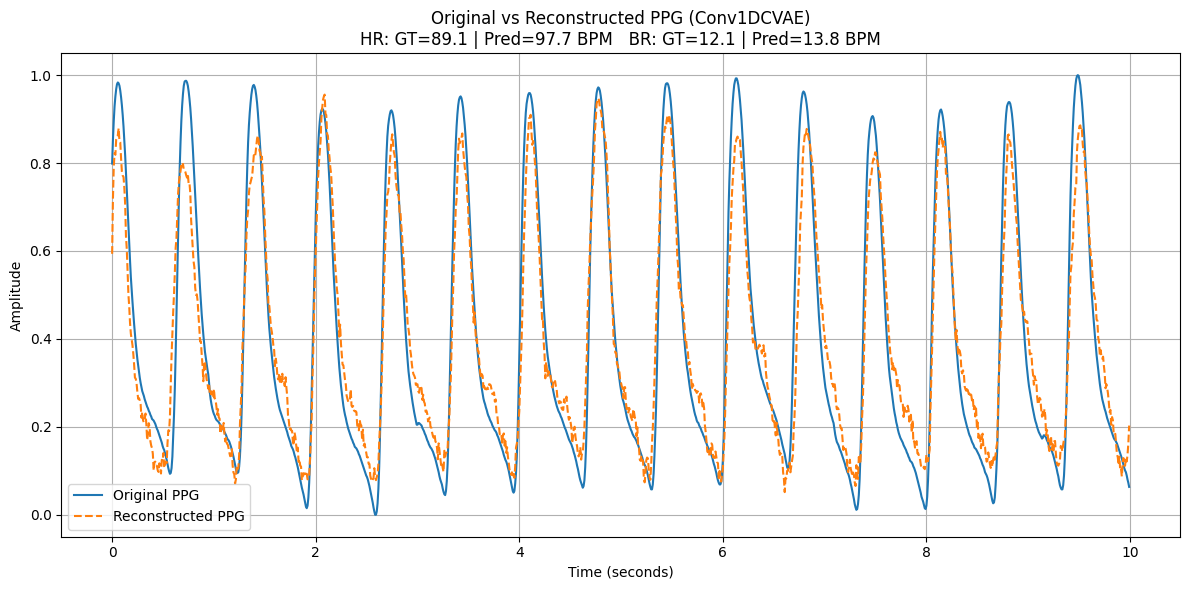

In [388]:
# Visualize kết quả của mô hình Conv1DCVAE
visualize_reconstruction_conv1d_cvae(model=conv1d_model,
                                     data_loader=test_loader,
                                     device=device,
                                     fs=125,
                                     dataset=test_dataset,
                                     num_samples=1)

In [389]:
def evaluate_model_hr_br_conv1d(model, data_loader, device, dataset):
    model.eval()
    hr_errors, br_errors = [], []
    hr_mean, hr_std = np.mean(dataset.hr_values), np.std(dataset.hr_values)
    br_mean, br_std = np.mean(dataset.br_values), np.std(dataset.br_values)

    with torch.no_grad():
        for signals, hr, br in data_loader:
            signals, hr, br = signals.to(device), hr.to(device), br.to(device)
            if signals.ndim == 2:
                signals = signals.unsqueeze(1)
            cond = torch.cat([hr, br], dim=1)
            _, _, _, hr_pred, br_pred = model(signals, cond)

            hr_gt_real = hr.cpu().numpy() * hr_std + hr_mean
            br_gt_real = br.cpu().numpy() * br_std + br_mean
            hr_pred_real = hr_pred.cpu().numpy() * hr_std + hr_mean
            br_pred_real = br_pred.cpu().numpy() * br_std + br_mean

            hr_errors.extend(np.abs(hr_pred_real - hr_gt_real))
            br_errors.extend(np.abs(br_pred_real - br_gt_real))

    print(f"Sai số trung bình toàn tập test dataset Conv1DCVAE (giá trị thực):")
    print(f"- HR: {np.mean(hr_errors):.2f} BPM")
    print(f"- BR: {np.mean(br_errors):.2f} BPM")
evaluate_model_hr_br_conv1d(conv1d_model, test_loader, device=device, dataset=test_dataset)

Sai số trung bình toàn tập test dataset Conv1DCVAE (giá trị thực):
- HR: 6.64 BPM
- BR: 1.31 BPM


## **V. Mô hình Transformer Generative**

In [390]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, seq_len=1250, num_layers=2, nhead=2, d_model=64, cond_dim=2):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.cond_dim = cond_dim

        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model, seq_len)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead),
            num_layers=num_layers
        )

        self.cond_linear = nn.Linear(cond_dim, d_model)
        self.decoder = nn.Linear(d_model, 1)

        self.hr_head = nn.Linear(d_model, 1)
        self.br_head = nn.Linear(d_model, 1)

    def forward(self, src, hr, br):
        src = src.unsqueeze(-1)  # [B, L, 1]
        src = self.embedding(src)
        src = self.pos_encoder(src)

        cond = torch.cat([hr, br], dim=1)
        cond_embed = self.cond_linear(cond).unsqueeze(1).expand(-1, self.seq_len, -1)

        src = src + cond_embed
        src = src.permute(1, 0, 2)  # [L, B, D]
        encoded = self.transformer_encoder(src)
        encoded = encoded.permute(1, 0, 2)  # [B, L, D]

        recon = self.decoder(encoded).squeeze(-1)
        hr_pred = self.hr_head(encoded.mean(dim=1))
        br_pred = self.br_head(encoded.mean(dim=1))

        return recon, hr_pred, br_pred

In [391]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len):
        super(PositionalEncoding, self).__init__()
        pe = self.create_positional_encoding(d_model, seq_len)
        self.register_buffer("pe", pe)

    def create_positional_encoding(self, d_model, seq_len):
        position = torch.arange(0, seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # [1, seq_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [392]:
def transformer_multitask_loss(recon_x, x, hr_pred, br_pred, hr_gt, br_gt,
                               alpha_recon=1.0, alpha_hr=1.0, alpha_br=1.0):
    loss_recon = F.mse_loss(recon_x, x)
    loss_hr = F.mse_loss(hr_pred, hr_gt)
    loss_br = F.mse_loss(br_pred, br_gt)
    return alpha_recon * loss_recon + alpha_hr * loss_hr + alpha_br * loss_br

In [393]:
from tqdm import tqdm
def train_transformer_multitask(model, train_loader, optimizer, device, num_epochs=50):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for signals, hr, br in loop:
            signals, hr, br = signals.to(device), hr.to(device), br.to(device)

            optimizer.zero_grad()
            recon_x, hr_pred, br_pred = model(signals, hr, br)
            loss = transformer_multitask_loss(recon_x, signals, hr_pred, br_pred, hr, br)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

In [394]:
def visualize_reconstruction_transformer(model, data_loader, dataset, device, fs=125, num_samples=3):
    model.eval()
    hr_mean, hr_std = np.mean(dataset.hr_values), np.std(dataset.hr_values)
    br_mean, br_std = np.mean(dataset.br_values), np.std(dataset.br_values)

    with torch.no_grad():
        for signals, hr, br in data_loader:
            signals, hr, br = signals.to(device), hr.to(device), br.to(device)
            recon_x, hr_pred, br_pred = model(signals, hr, br)

            for j in range(min(num_samples, signals.size(0))):
                gt_ppg = signals[j].cpu().numpy()
                pred_ppg = recon_x[j].cpu().numpy()

                hr_gt = hr[j].item() * hr_std + hr_mean
                br_gt = br[j].item() * br_std + br_mean
                hr_pd = hr_pred[j].item() * hr_std + hr_mean
                br_pd = br_pred[j].item() * br_std + br_mean

                plt.figure(figsize=(12, 6))
                plt.plot(np.arange(len(gt_ppg)) / fs, gt_ppg, label='Original PPG')
                plt.plot(np.arange(len(pred_ppg)) / fs, pred_ppg, '--', label='Reconstructed PPG')
                plt.title(f"Original vs Reconstructed PPG (Transformer)\nHR: GT={hr_gt:.1f} | Pred={hr_pd:.1f} BPM   BR: GT={br_gt:.1f} | Pred={br_pd:.1f} BPM")
                plt.xlabel("Time (seconds)")
                plt.ylabel("Amplitude")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            break

In [395]:
import torch
import torch.optim as optim
from tqdm import tqdm


# Chọn thiết bị (GPU nếu có, CPU nếu không)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo mô hình Transformer
seq_len = 1250  # Độ dài của tín hiệu PPG
d_model = 64  # Kích thước embedding
nhead = 2  # Số lượng attention heads
num_layers = 2  # Số lượng lớp encoder
cond_dim = 2 # hr and br

transformer_model = TransformerModel(seq_len=seq_len, d_model=d_model, nhead=nhead, num_layers=num_layers, cond_dim = cond_dim)

# Tạo optimizer cho mô hình Transformer
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Train mô hình Transformer
num_epochs = 50
train_transformer_multitask(
    model=transformer_model,
    train_loader=train_loader,
    optimizer=transformer_optimizer,
    device=device,
    num_epochs=50
)
print(f"\nHuấn luyện mô hình Transformer thành công")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.0404]


Epoch 1: Loss = 0.3314


Epoch 2/50: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.0162]


Epoch 2: Loss = 0.0273


Epoch 3/50: 100%|██████████| 65/65 [00:09<00:00,  6.55it/s, loss=0.0076]


Epoch 3: Loss = 0.0122


Epoch 4/50: 100%|██████████| 65/65 [00:09<00:00,  6.53it/s, loss=0.00601]


Epoch 4: Loss = 0.0068


Epoch 5/50: 100%|██████████| 65/65 [00:09<00:00,  6.53it/s, loss=0.00364]


Epoch 5: Loss = 0.0049


Epoch 6/50: 100%|██████████| 65/65 [00:09<00:00,  6.57it/s, loss=0.0031]


Epoch 6: Loss = 0.0044


Epoch 7/50: 100%|██████████| 65/65 [00:09<00:00,  6.57it/s, loss=0.00455]


Epoch 7: Loss = 0.0040


Epoch 8/50: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.00499]


Epoch 8: Loss = 0.0043


Epoch 9/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00279]


Epoch 9: Loss = 0.0050


Epoch 10/50: 100%|██████████| 65/65 [00:09<00:00,  6.58it/s, loss=0.00284]


Epoch 10: Loss = 0.0054


Epoch 11/50: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.00264]


Epoch 11: Loss = 0.0036


Epoch 12/50: 100%|██████████| 65/65 [00:09<00:00,  6.57it/s, loss=0.00305]


Epoch 12: Loss = 0.0031


Epoch 13/50: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.00192]


Epoch 13: Loss = 0.0032


Epoch 14/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00424]


Epoch 14: Loss = 0.0025


Epoch 15/50: 100%|██████████| 65/65 [00:09<00:00,  6.57it/s, loss=0.00338]


Epoch 15: Loss = 0.0042


Epoch 16/50: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.00289]


Epoch 16: Loss = 0.0031


Epoch 17/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.00368]


Epoch 17: Loss = 0.0037


Epoch 18/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.00479]


Epoch 18: Loss = 0.0041


Epoch 19/50: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.00207]


Epoch 19: Loss = 0.0041


Epoch 20/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00469]


Epoch 20: Loss = 0.0034


Epoch 21/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00177]


Epoch 21: Loss = 0.0028


Epoch 22/50: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.00361]


Epoch 22: Loss = 0.0024


Epoch 23/50: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.00379]


Epoch 23: Loss = 0.0032


Epoch 24/50: 100%|██████████| 65/65 [00:09<00:00,  6.63it/s, loss=0.00193]


Epoch 24: Loss = 0.0038


Epoch 25/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00133]


Epoch 25: Loss = 0.0017


Epoch 26/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00146]


Epoch 26: Loss = 0.0017


Epoch 27/50: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.00128]


Epoch 27: Loss = 0.0015


Epoch 28/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.00883]


Epoch 28: Loss = 0.0022


Epoch 29/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.0197]


Epoch 29: Loss = 0.0098


Epoch 30/50: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.00193]


Epoch 30: Loss = 0.0043


Epoch 31/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00788]


Epoch 31: Loss = 0.0045


Epoch 32/50: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.00222]


Epoch 32: Loss = 0.0055


Epoch 33/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.00115]


Epoch 33: Loss = 0.0026


Epoch 34/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.000759]


Epoch 34: Loss = 0.0012


Epoch 35/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.00212]


Epoch 35: Loss = 0.0015


Epoch 36/50: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.00197]


Epoch 36: Loss = 0.0016


Epoch 37/50: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, loss=0.00354]


Epoch 37: Loss = 0.0042


Epoch 38/50: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, loss=0.00146]


Epoch 38: Loss = 0.0044


Epoch 39/50: 100%|██████████| 65/65 [00:09<00:00,  6.63it/s, loss=0.000809]


Epoch 39: Loss = 0.0016


Epoch 40/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.000887]


Epoch 40: Loss = 0.0015


Epoch 41/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.000833]


Epoch 41: Loss = 0.0015


Epoch 42/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.00227]


Epoch 42: Loss = 0.0017


Epoch 43/50: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.000937]


Epoch 43: Loss = 0.0016


Epoch 44/50: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.000853]


Epoch 44: Loss = 0.0013


Epoch 45/50: 100%|██████████| 65/65 [00:09<00:00,  6.63it/s, loss=0.00117]


Epoch 45: Loss = 0.0008


Epoch 46/50: 100%|██████████| 65/65 [00:09<00:00,  6.61it/s, loss=0.00142]


Epoch 46: Loss = 0.0014


Epoch 47/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.00293]


Epoch 47: Loss = 0.0027


Epoch 48/50: 100%|██████████| 65/65 [00:09<00:00,  6.63it/s, loss=0.00143]


Epoch 48: Loss = 0.0020


Epoch 49/50: 100%|██████████| 65/65 [00:09<00:00,  6.63it/s, loss=0.00215]


Epoch 49: Loss = 0.0029


Epoch 50/50: 100%|██████████| 65/65 [00:09<00:00,  6.62it/s, loss=0.0041]

Epoch 50: Loss = 0.0018

Huấn luyện mô hình Transformer thành công


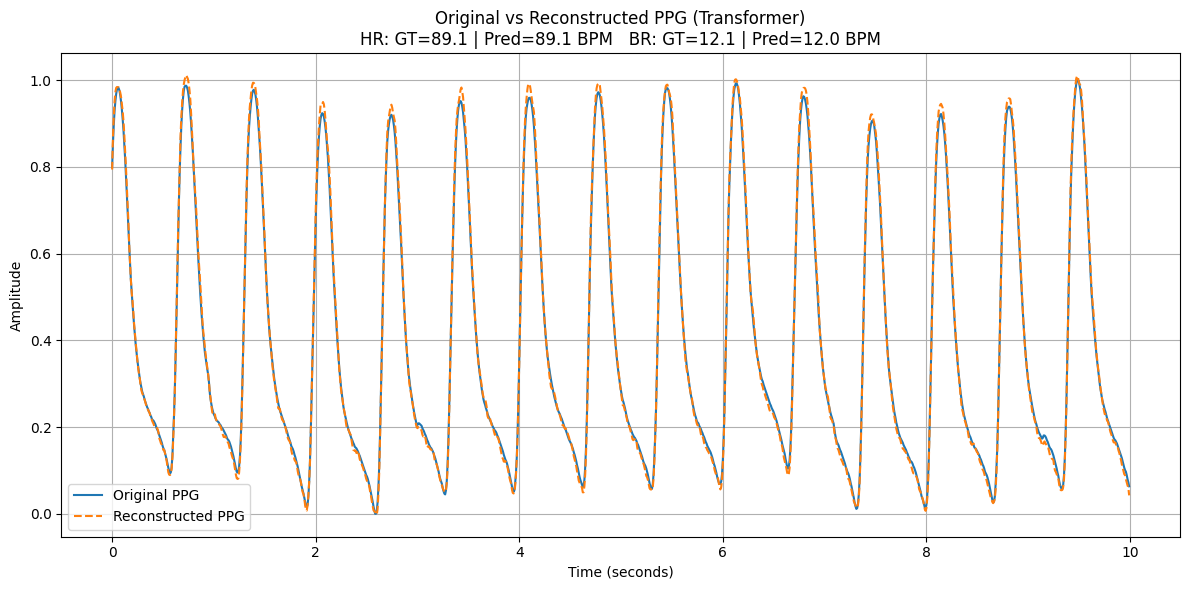

In [396]:
visualize_reconstruction_transformer(
    model=transformer_model,
    data_loader=test_loader,
    dataset=test_dataset,
    device=device,
    fs=125,
    num_samples=1
)

In [397]:
def evaluate_hr_br_transformer(model, test_loader, dataset, device):
    model.eval()
    hr_errors = []
    br_errors = []

    hr_mean, hr_std = np.mean(dataset.hr_values), np.std(dataset.hr_values)
    br_mean, br_std = np.mean(dataset.br_values), np.std(dataset.br_values)

    with torch.no_grad():
        for signals, hr, br in test_loader:
            signals, hr, br = signals.to(device), hr.to(device), br.to(device)
            _, hr_pred, br_pred = model(signals, hr, br)

            hr_real = hr.cpu().numpy() * hr_std + hr_mean
            br_real = br.cpu().numpy() * br_std + br_mean
            hr_pred_real = hr_pred.cpu().numpy() * hr_std + hr_mean
            br_pred_real = br_pred.cpu().numpy() * br_std + br_mean

            hr_errors.extend(np.abs(hr_real - hr_pred_real))
            br_errors.extend(np.abs(br_real - br_pred_real))

    print(f"Sai số trung bình toàn tập test dataset Transformer (giá trị thực):")
    print(f"- HR MAE: {np.mean(hr_errors):.2f} BPM")
    print(f"- BR MAE: {np.mean(br_errors):.2f} BPM")
evaluate_hr_br_transformer(transformer_model, test_loader, test_dataset, device)

Sai số trung bình toàn tập test dataset Transformer (giá trị thực):
- HR MAE: 0.61 BPM
- BR MAE: 0.13 BPM


## **VI. Đánh giá mô hình (các mô hình tạo sinh)**

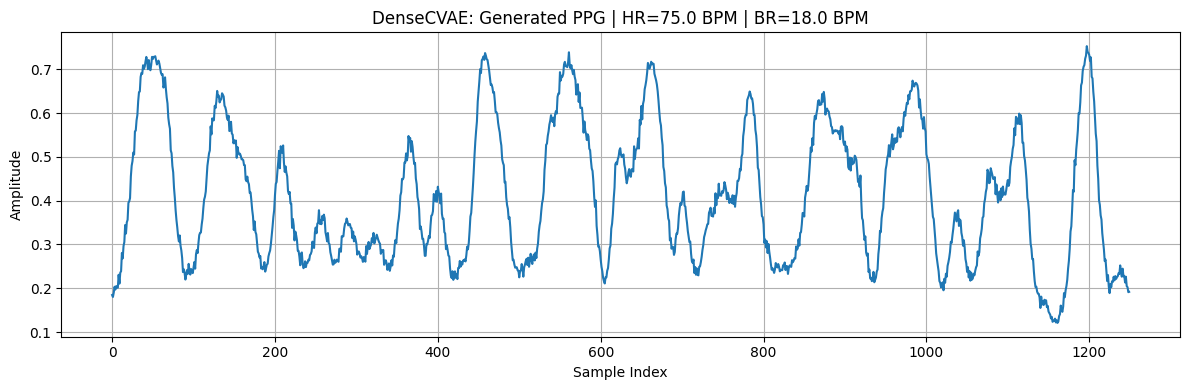

In [407]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Thông số HR và BR mong muốn
hr_val = 75.0  # BPM
br_val = 18.0  # BPM

hr_norm = (hr_val - hr_mean) / hr_std
br_norm = (br_val - br_mean) / br_std
cond = torch.tensor([[hr_norm, br_norm]], dtype=torch.float32).to(device)

# Sinh latent vector z ngẫu nhiên
z = torch.randn((1, dense_model.latent_dim)).to(device)

# Giải mã z kết hợp điều kiện HR/BR để sinh PPG
dense_model.eval()
with torch.no_grad():
    x_gen, _, _ = dense_model.decode(z, cond)  # chỉ lấy PPG output
    ppg_generated_dense = x_gen.cpu().numpy().flatten()

# Vẽ tín hiệu sinh ra
plt.figure(figsize=(12, 4))
plt.plot(ppg_generated_dense)
plt.title(f"DenseCVAE: Generated PPG | HR={hr_val} BPM | BR={br_val} BPM")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

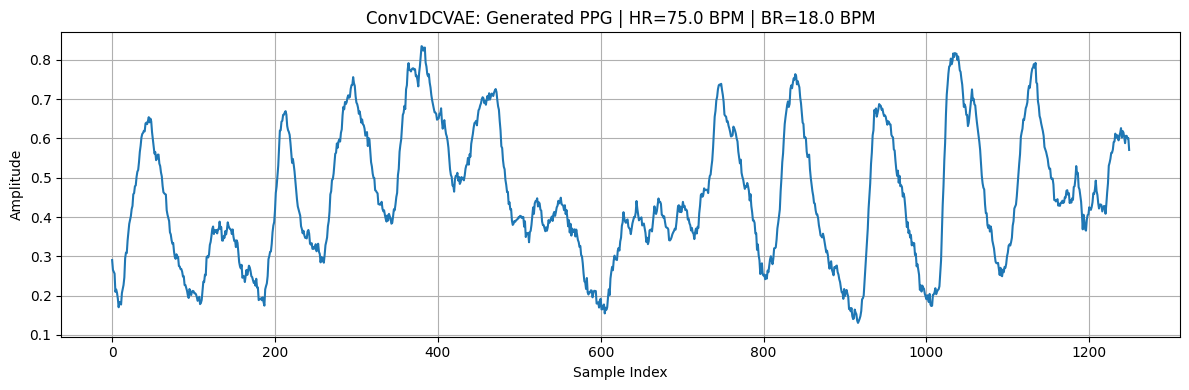

In [412]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Thông số HR và BR mong muốn
hr_val = 75.0  # BPM
br_val = 18.0  # BPM

hr_norm = (hr_val - hr_mean) / hr_std
br_norm = (br_val - br_mean) / br_std
cond = torch.tensor([[hr_norm, br_norm]], dtype=torch.float32).to(device)

# Sinh latent vector z ngẫu nhiên
z = torch.randn((1, conv1d_model.latent_dim)).to(device)

# Giải mã z kết hợp điều kiện HR/BR để sinh PPG
conv1d_model.eval()
with torch.no_grad():
    x_gen = conv1d_model.decode(z, cond)  # chỉ lấy PPG output
    ppg_generated_conv = x_gen.cpu().numpy().flatten()

# Vẽ tín hiệu sinh ra
plt.figure(figsize=(12, 4))
plt.plot(ppg_generated_conv)
plt.title(f"Conv1DCVAE: Generated PPG | HR={hr_val} BPM | BR={br_val} BPM")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

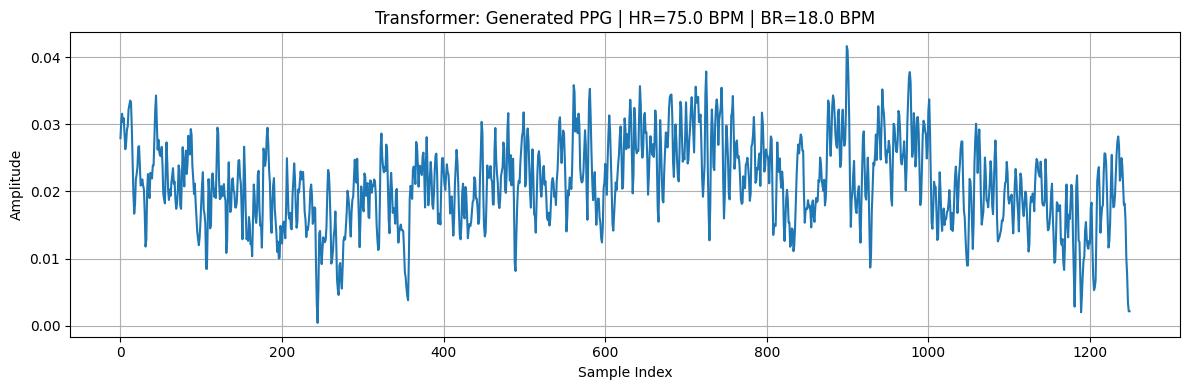

In [413]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Nhập HR và BR mong muốn
hr_val = 75.0  # BPM
br_val = 18.0  # BPM

hr_norm = (hr_val - hr_mean) / hr_std
br_norm = (br_val - br_mean) / br_std
hr_tensor = torch.tensor([[hr_norm]], dtype=torch.float32).to(device)
br_tensor = torch.tensor([[br_norm]], dtype=torch.float32).to(device)

# Tín hiệu đầu vào là zeros
src_input = torch.zeros((1, transformer_model.seq_len), dtype=torch.float32).to(device)

# Tạo sinh PPG
transformer_model.eval()
with torch.no_grad():
    ppg_generated, _, _ = transformer_model(src_input, hr_tensor, br_tensor)
    ppg_generated_np = ppg_generated.squeeze().cpu().numpy()

# Vẽ tín hiệu sinh ra
plt.figure(figsize=(12, 4))
plt.plot(ppg_generated_np)
plt.title(f"Transformer: Generated PPG | HR={hr_val} BPM | BR={br_val} BPM")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()